# CAPSTONE PROJECT

This is my submission for the final project which I have completed with the help of all that I have learned over the course of these weeks.

### The Search for Exoplanets Similar to the Planets in our Solar System and an analysis of Perception of Extraterrestrial Life

#### Objective -
The purpose here is to find out exoplanets that resemble the planets in our solar system by drawing comparisons between their physical and orbital characteristics. After deriving these comparisons, we will also analyse how people's perception of extraterrestrial life and space science have evolved over time.

### Dataset Description -
I have used the following datasets for this project:

1. I used the pandas directory to upload data from the NASA Exoplanet Archive. Using this data, I am going to draw comparisons between exoplanets and the planets in our solar system.
2. I used the async PRAW directory to get Reddit APIs so that I can identify and plot trends about what people are interested in with regards to space science. I chose Reddit as it is about 20 years old and is not recent like many other social media platforms. It has a question and answer format which makes it easier to understand trends.
3. And I have used dataset from Our World in Data to analyse the evolution of exoplanetary science over the years.

I am also making a reference dataset including the properties of the planets in our solar system to set up parameters for comparison between the former and the exoplanets in our cleaned dataset.

from google.colab import files
uploaded = files.upload()   

In [4]:
%pip install asyncpraw

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
#Importing all the necessary tools first

import numpy as np #For the arrays
import pandas as pd #For the Dataframes
from scipy import stats #For the statistics
import statsmodels.api as sm #For statistical modeling
import matplotlib.pyplot as plt #For the plots
import seaborn as sns #For the Graphics of the plotting
import warnings as wr
import asyncpraw as praw
from datetime import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
#Here is a dictionary for the reference dataset.
"""
I am going to include the name of the planet, their orbital period in days,
their planetary radius expressed in Earth radius, mass expressed in Earth radius,
their equilibrium temperature, and their number of moons.
"""

reference_solar_system = [
    {'pl_name': 'Mercury', 'pl_orbper': 88.0, 'pl_rade': 0.38, 'pl_masse': 0.0553, 'pl_eqt': 440.0, 'sy_mnum': 0},
    {'pl_name': 'Venus', 'pl_orbper': 224.7, 'pl_rade': 0.95, 'pl_masse': 0.815, 'pl_eqt': 230.0, 'sy_mnum': 0},
    {'pl_name': 'Earth', 'pl_orbper': 365.2, 'pl_rade': 1.00, 'pl_masse': 1, 'pl_eqt': 255.0, 'sy_mnum': 1},
    {'pl_name': 'Mars', 'pl_orbper': 687.0, 'pl_rade': 0.53, 'pl_masse': 0.107, 'pl_eqt': 210.0,'sy_mnum': 2},
    {'pl_name': 'Jupiter', 'pl_orbper': 4331, 'pl_rade': 11.21, 'pl_masse': 317.8, 'pl_eqt': 112.0, 'sy_mnum': 95},
    {'pl_name': 'Saturn', 'pl_orbper': 10747.0, 'pl_rade': 9.45, 'pl_masse': 95.2, 'pl_eqt': 84.0, 'sy_mnum': 274},
    {'pl_name': 'Uranus', 'pl_orbper': 30589.0, 'pl_rade': 4.01,'pl_masse': 14.5, 'pl_eqt': 59.0, 'sy_mnum': 28},
    {'pl_name': 'Neptune', 'pl_orbper': 59800.0, 'pl_rade': 3.88, 'pl_masse': 17.1, 'pl_eqt': 46.0, 'sy_mnum': 16},
]

In [8]:
#Creating the reference DataFrame from the list of dictionaries
reference_df = pd.DataFrame(reference_solar_system)

display(reference_df)

,pl_name,pl_orbper,pl_rade,pl_masse,pl_eqt,sy_mnum
0,Mercury,88.0,0.38,0.0553,440.0,0
1,Venus,224.7,0.95,0.8150,230.0,0
2,Earth,365.2,1.00,1.0000,255.0,1
3,Mars,687.0,0.53,0.1070,210.0,2
4,Jupiter,4331.0,11.21,317.8000,112.0,95
5,Saturn,10747.0,9.45,95.2000,84.0,274
6,Uranus,30589.0,4.01,14.5000,59.0,28
7,Neptune,59800.0,3.88,17.1000,46.0,16


In [9]:
#This is how I have extracted the Reddit dataset.
async def fetch_reddit_posts():
    reddit = praw.Reddit(
        client_id="KJ8z3-_T8qtEAVxNwRAgBg",
        client_secret="c3OcyahpO_WmNx7JCbo7AngkGQPshg",
        user_agent="perception_project"
    )

    # Choose subreddit and keyword
    subreddit = await reddit.subreddit("aliens+extraterrestrial+exoplanet+astrobiology+exoplanets+space+astronomy+AskReddit")
    posts = []

    keywords = ["extraterrestrial", "aliens", "exoplanet", "astrobiology", "space", "astronomy"]

    for keyword in keywords:
      async for post in subreddit.search(keyword, limit=1000):
          posts.append({
              "title": post.title,
              "selftext": post.selftext,
              "score": post.score,
              "num_comments": post.num_comments,
              "created": post.created_utc
          })

    return posts

# Run the asynchronous function
import asyncio
posts_list = await fetch_reddit_posts()

# Convert to DataFrame
dfr = pd.DataFrame(posts_list)
dfr.to_csv("reddit_extraterrestrial.csv", index=False)

In [10]:
#This is the third and last dataset for the plot telling us about the exoplanet discoveries over the years.
import requests

# Fetch the data.
dfplt = pd.read_csv("https://ourworldindata.org/grapher/cumulative-exoplanets-by-method.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/cumulative-exoplanets-by-method.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

In [11]:
dfplt.head()

,Entity,Code,Year,n_planets_cumulative
0,Microlensing,NaN,1992,0
1,Microlensing,NaN,1993,0
2,Microlensing,NaN,1994,0
3,Microlensing,NaN,1995,0
4,Microlensing,NaN,1996,0


### Data Cleaning/Preprocessing

In [12]:
#We start by loading the data from the downloaded CSV file and then, proceed to clean it.

df = pd.read_csv('PS_2025.07.01_02.15.44.csv')

df.head() #I use this to check the first 5 rows of the data I have uploaded on my colab file.
#Since all the columns I wanted have been loaded properly, I proceed further.

,loc_rowid,pl_name,hostname,default_flag,sy_mnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_rade,pl_masse,pl_eqt,sy_dist
0,1,11 Com b,11 Com,1,0,Radial Velocity,2007,Xinglong Station,323.21,NaN,NaN,NaN,93.1846
1,2,11 Com b,11 Com,0,0,Radial Velocity,2007,Xinglong Station,NaN,NaN,NaN,NaN,93.1846
2,3,11 Com b,11 Com,0,0,Radial Velocity,2007,Xinglong Station,326.03,NaN,NaN,NaN,93.1846
3,4,11 UMi b,11 UMi,0,0,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,NaN,NaN,NaN,NaN,125.3210
4,5,11 UMi b,11 UMi,0,0,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,516.22,NaN,NaN,NaN,125.3210


In [13]:
print(f"Rows before cleaning: {len(df)}") #Just to check how much data I am dealing with.

Rows before cleaning: 38509


In [14]:
#Now onto the cleaning.
df = df.dropna()
print(f"Rows after cleaning: {len(df)}")

Rows after cleaning: 1584


In [15]:
df.describe() #We can check the stats for our columns this way.

,loc_rowid,default_flag,sy_mnum,disc_year,pl_orbper,pl_rade,pl_masse,pl_eqt,sy_dist
count,1584.000000,1584.000000,1584.0,1584.000000,1.584000e+03,1584.000000,1584.000000,1584.000000,1584.000000
mean,21875.631313,0.590278,0.0,2016.963384,2.538386e+05,8.969665,337.618545,1182.819659,288.398951
std,16250.162277,0.491938,0.0,5.491041,1.010063e+07,5.980180,711.075712,547.224292,311.381345
min,120.000000,0.000000,0.0,1999.000000,1.797150e-01,0.309800,0.070000,134.400000,6.531270
25%,3180.250000,0.000000,0.0,2012.750000,2.751158e+00,2.592000,10.000000,722.000000,80.540700
50%,34754.500000,1.000000,0.0,2018.000000,4.139707e+00,10.525242,121.228483,1163.500000,190.148500
75%,36387.750000,1.000000,0.0,2022.000000,9.314174e+00,13.775861,349.611248,1585.677500,373.427500
max,38464.000000,1.000000,0.0,2025.000000,4.020000e+08,23.430000,8899.195396,4050.000000,2501.750000


In [16]:
#Let's check one more thing- if any column has any null values.
df.isnull().sum()

loc_rowid          0
pl_name            0
hostname           0
default_flag       0
sy_mnum            0
discoverymethod    0
disc_year          0
disc_facility      0
pl_orbper          0
pl_rade            0
pl_masse           0
pl_eqt             0
sy_dist            0
dtype: int64

In [17]:
#I will also clean the reddit data I uploaded.
print(f"Rows before cleaning: {len(dfr)}")

Rows before cleaning: 1406


In [18]:
dfr = dfr.dropna()
print(f"Rows after cleaning: {len(dfr)}")

Rows after cleaning: 1406


In [19]:
dfr['created_utc'] = pd.to_datetime(dfr['created'], unit='s')
#I have included this step to ensure that I can show my results on a timeline.

In [20]:
#Onto cleaning the graph data.
if 'n_planets_cumulative' in dfplt.columns:
    dfplt = dfplt.groupby('Year')['n_planets_cumulative'].sum().reset_index()
    dfplt.rename(columns={'n_planets_cumulative': 'total_discoveries'}, inplace=True)
else:
    print("Column 'n_planets_cumulative' not found. Data may have already been processed.")

Okay, we are down to a much lower number now just with this one step and we have also checked that no column has an empty value. All the entries which were empty have been cleaned to ensure that we are dealing with exoplanets which have all the data required to make the analysis.
Before starting with the analysis, we can explore this data and answer some questions about the exoplanets we might have.

#### What does the distribution of the number of moons for the exoplanets look like?


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000001B8E8C5A780>


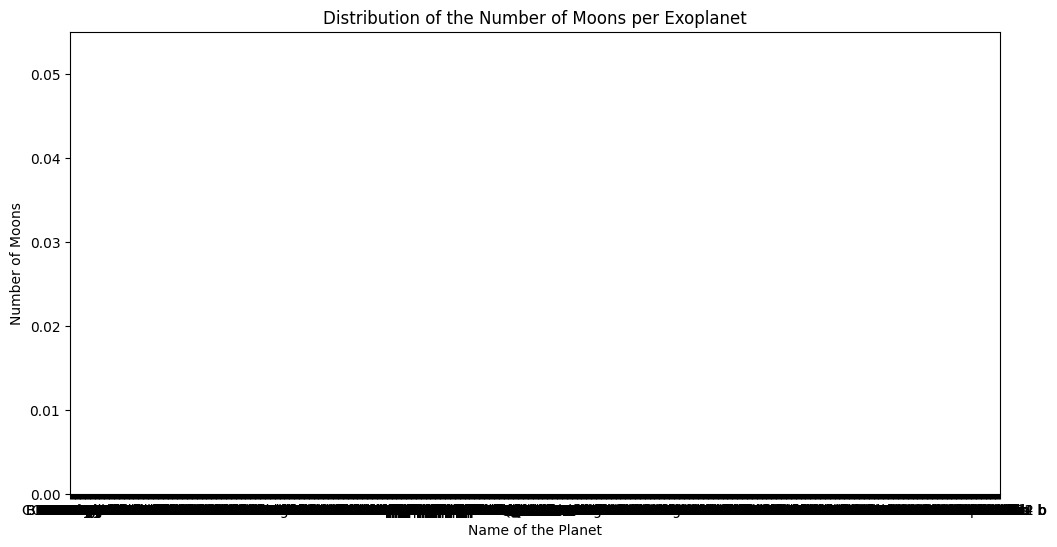

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='pl_name', y='sy_mnum')
plt.title('Distribution of the Number of Moons per Exoplanet')
plt.xlabel('Name of the Planet') #How many moons do they have?
plt.ylabel('Number of Moons') #How many planets have this many moons?
plt.ylim(bottom=0) #I included this piece of code here because matplotlib was adding padding to my plot and causing the values in the y-axis to start from -0.04 even if there are no values below 0 in the dataframe.
plt.show()

The dark bold link in place of the x-axis labels is that way because of the many names of the exoplanets. This graph shows us that none of the exoplanets in our dataframe has a recorded moon, which is astonishing to say the least.
As compared to this, if we make the same plot for the planets in our solar system.

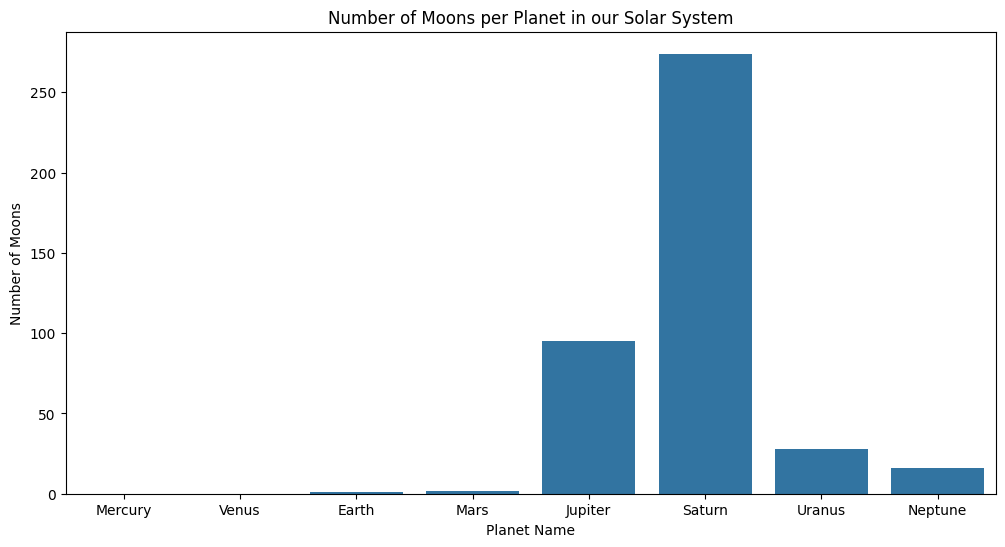

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(data=reference_df, x='pl_name', y='sy_mnum')
plt.title('Number of Moons per Planet in our Solar System')
plt.xlabel('Planet Name')
plt.ylabel('Number of Moons')
plt.show()

#### Analysis of the Data
In the reference dataset above, we specified the values for the planets' properties, but this provides a limited range for us to match the exoplanets with the planets in our solar system. Hence, I will now define 'bins' (similar to the ones in the graph above' for the planets to fit into. This will make comparison and sorting easier.

In [23]:
#For the Planetary Radius
radius_bins = {
    'Mercury': (0.3, 0.49),
    'Venus': (0.85, 0.99),
    'Earth': (1.00, 2.95),
    'Mars': (0.5, 0.84),
    'Jupiter': (10, 12),
    'Saturn': (8.0, 10),
    'Uranus': (4.0, 8.0),
    'Neptune': (3.0, 4.0)
}

#These ranges ensure that our exoplanets fall under categories of similarity. Now we match the planet's radius to a given exoplanet radius.
def match_radius_to_planet(radius, bins):
    for planet, (low, high) in bins.items():
        if low <= radius <= high:
            return planet
    return 'Unmatched'

df['radius_match'] = df['pl_rade'].apply(lambda x: match_radius_to_planet(x, radius_bins))
display(df[['pl_name', 'pl_rade', 'radius_match']])


,pl_name,pl_rade,radius_match
119,55 Cnc e,2.080000,Earth
171,AU Mic b,4.070000,Uranus
178,AU Mic c,3.240000,Neptune
195,BD+20 594 b,2.230000,Earth
218,BD-14 3065 b,21.590000,Unmatched
...,...,...,...
38354,XO-5 b,12.206601,Unmatched
38361,XO-6 b,23.202630,Unmatched
38369,XO-7 b,15.389957,Unmatched
38461,pi Men c,2.060000,Earth


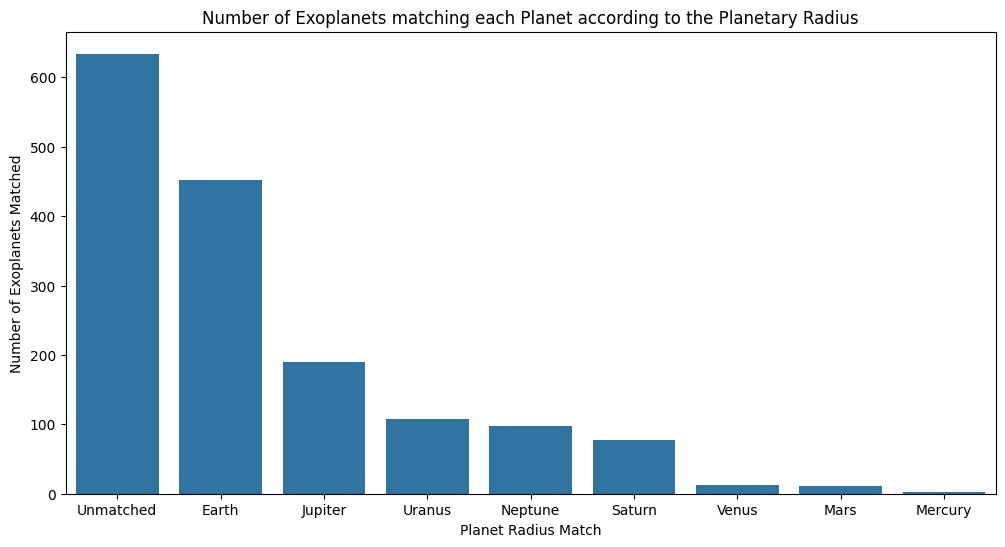

In [24]:
#I want to plot the radius match planets and the number of exoplanets they have matched with. For this, I will count the matches first.
radius_match_counts = df['radius_match'].value_counts().reset_index()
radius_match_counts.columns = ['Planet Match', 'Number of Exoplanets']

#Now we plot!
plt.figure(figsize=(12, 6))
sns.barplot(x='Planet Match', y='Number of Exoplanets', data=radius_match_counts)
plt.title('Number of Exoplanets matching each Planet according to the Planetary Radius')
plt.xlabel('Planet Radius Match')
plt.ylabel('Number of Exoplanets Matched')
plt.show()

So, as it turns out, if it were upto the Planetary radius, we would have quite a lot of unmatched planets - this means that a lot of exoplanets are bigger or smaller than the planets in our solar system. When matched, they match the most with Earth and Jupiter, with the least number of planets matching with Mercury.

Let's move onto a comparison between Planetary Mass now.

In [25]:
#I use the same code
#For the Planetary Mass
mass_bins = {
    'Mercury': (0.0001, 0.1),
    'Venus': (0.8, 0.99),
    'Earth': (1.00, 5.0),
    'Mars': (0.1, 0.8),
    'Jupiter': (200, 400),
    'Saturn': (80.0, 200),
    'Uranus': (13.0, 17.0),
    'Neptune': (17.0, 20.0)
}

#These ranges ensure that our exoplanets fall under categories of similarity. Now we match the planet's radius to a given exoplanet mass.
def match_mass_to_planet(mass, bins):
    for planet, (low, high) in bins.items():
        if low <= mass <= high:
            return planet
    return 'Unmatched'

df['mass_match'] = df['pl_masse'].apply(lambda x: match_mass_to_planet(x, mass_bins))
display(df[['pl_name', 'pl_masse', 'mass_match']])


,pl_name,pl_masse,mass_match
119,55 Cnc e,7.81000,Unmatched
171,AU Mic b,17.00000,Uranus
178,AU Mic c,13.60000,Uranus
195,BD+20 594 b,16.30000,Uranus
218,BD-14 3065 b,3932.00000,Unmatched
...,...,...,...
38354,XO-5 b,344.52772,Jupiter
38361,XO-6 b,1398.45200,Unmatched
38369,XO-7 b,225.34147,Jupiter
38461,pi Men c,4.52000,Earth


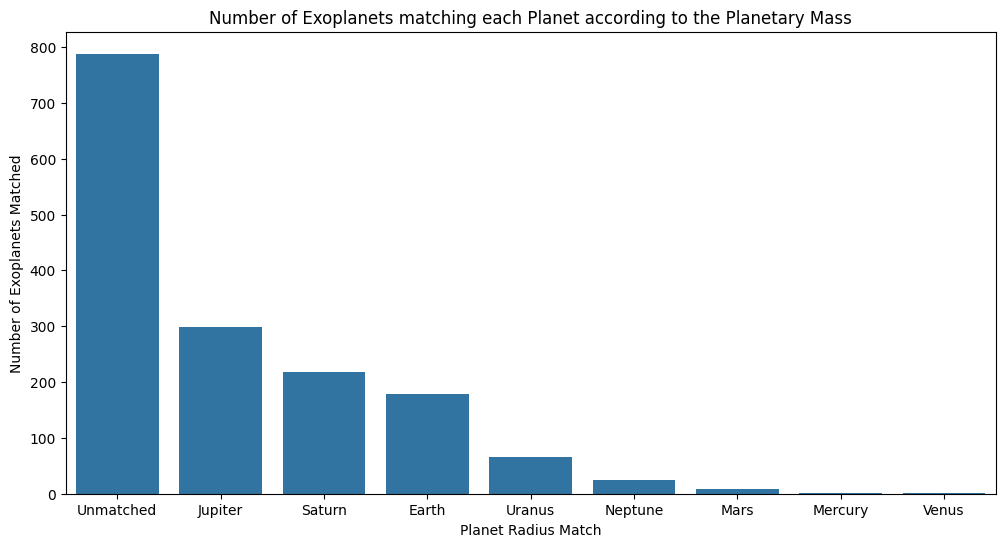

In [26]:
#Let's count again.
mass_match_counts = df['mass_match'].value_counts().reset_index()
mass_match_counts.columns = ['Planet Match', 'Number of Exoplanets']

#Now we plot!
plt.figure(figsize=(12, 6))
sns.barplot(x='Planet Match', y='Number of Exoplanets', data=mass_match_counts)
plt.title('Number of Exoplanets matching each Planet according to the Planetary Mass')
plt.xlabel('Planet Radius Match')
plt.ylabel('Number of Exoplanets Matched')
plt.show()

Let's make a comparison between the orbital period of the planets now. Since, we have the equilibrium temperature too, I will write the code for it too and then, plot both comparisons using the subplot option.

In [27]:
#For the Orbital Period
orbital_bins = {
    'Mercury': (50, 100),
    'Venus': (100, 300),
    'Earth': (300, 600),
    'Mars': (400, 1000),
    'Jupiter': (1000, 5000),
    'Saturn': (5000, 11000),
    'Uranus': (11000, 40000),
    'Neptune': (40000, 60000)
}

def match_orbital_to_planet(orbital, bins):
    for planet, (low, high) in bins.items():
        if low <= orbital <= high:
            return planet
    return 'Unmatched'

df['orbper_match'] = df['pl_orbper'].apply(lambda x: match_orbital_to_planet(x, orbital_bins))
display(df[['pl_name', 'pl_orbper', 'orbper_match']])

,pl_name,pl_orbper,orbper_match
119,55 Cnc e,0.736544,Unmatched
171,AU Mic b,8.463000,Unmatched
178,AU Mic c,18.859019,Unmatched
195,BD+20 594 b,41.685500,Unmatched
218,BD-14 3065 b,4.288973,Unmatched
...,...,...,...
38354,XO-5 b,4.187757,Unmatched
38361,XO-6 b,3.765001,Unmatched
38369,XO-7 b,2.864142,Unmatched
38461,pi Men c,6.268340,Unmatched


In [28]:
#For the Equilibrium Temperature
temperature_bins = {
    'Mercury': (300, 1000),
    'Venus': (230, 250),
    'Earth': (250, 300),
    'Mars': (200, 230),
    'Jupiter': (100, 200),
    'Saturn': (60, 100),
    'Uranus': (50, 60),
    'Neptune': (10, 50)
}

def match_temperature_to_planet(temperature, bins):
    for planet, (low, high) in bins.items():
        if low <= temperature <= high:
            return planet
    return 'Unmatched'

df['temperature_match'] = df['pl_eqt'].apply(lambda x: match_temperature_to_planet(x, temperature_bins))
display(df[['pl_name', 'pl_eqt', 'temperature_match']])

,pl_name,pl_eqt,temperature_match
119,55 Cnc e,1958.0,Unmatched
171,AU Mic b,593.0,Mercury
178,AU Mic c,454.0,Mercury
195,BD+20 594 b,546.0,Mercury
218,BD-14 3065 b,2001.0,Unmatched
...,...,...,...
38354,XO-5 b,1203.0,Unmatched
38361,XO-6 b,1577.0,Unmatched
38369,XO-7 b,1743.0,Unmatched
38461,pi Men c,1147.0,Unmatched


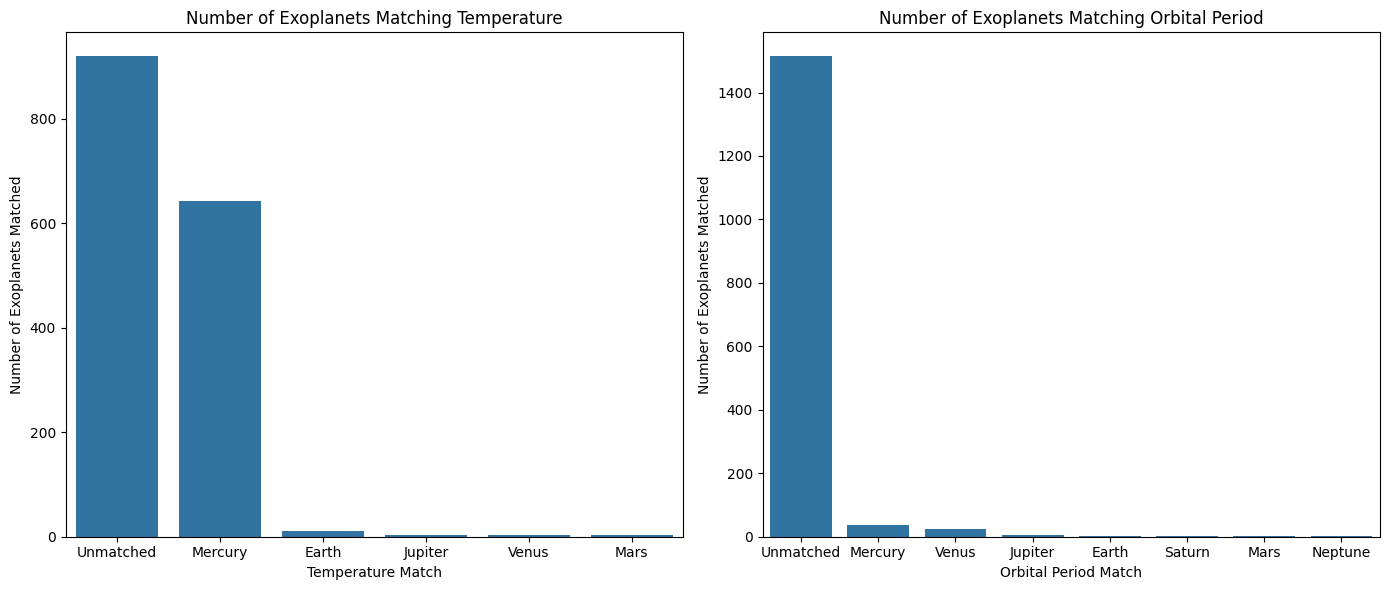

In [29]:
#Counting for Orbital periods
orbper_match_counts = df['orbper_match'].value_counts().reset_index()
orbper_match_counts.columns = ['Planet Match', 'Number of Exoplanets']

#Counting for Equilibrium Temperature
eqt_match_counts = df['temperature_match'].value_counts().reset_index()
eqt_match_counts.columns = ['Planet Match', 'Number of Exoplanets']

#Now we subplot!
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the Equilibrium Temperature Match Counts
sns.barplot(x='Planet Match', y='Number of Exoplanets', data=eqt_match_counts, ax=ax[0])
ax[0].set_title('Number of Exoplanets Matching Temperature')
ax[0].set_xlabel('Temperature Match')
ax[0].set_ylabel('Number of Exoplanets Matched')

# Plot for the Orbital Period Match Counts
sns.barplot(x='Planet Match', y='Number of Exoplanets', data=orbper_match_counts, ax=ax[1])
ax[1].set_title('Number of Exoplanets Matching Orbital Period')
ax[1].set_xlabel('Orbital Period Match')
ax[1].set_ylabel('Number of Exoplanets Matched')

fig.tight_layout()
plt.show()

This was the one-on-one comparison between every property of the planets. For better clarity, I will try to compile the properties into one table.

#### How do we check whether the exoplanet in question is a Terrestrial Planet or a Gas Giant?

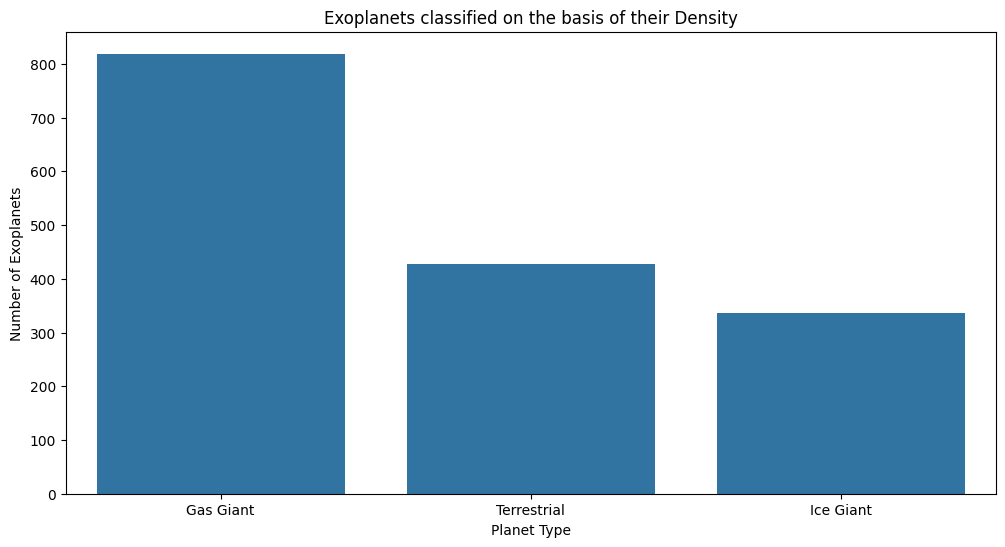

In [30]:
#Let's calculate the density in g/cm^3 for this purpose.
#Since, we are dealing with Earth units, we can take the formula:

df['density'] = (5.51*df['pl_masse'])/np.power(df['pl_rade'], 3)
reference_df['density'] = (5.51*reference_df['pl_masse'])/np.power(reference_df['pl_rade'], 3)

#Let's analyse which category each exoplanet falls into now - Terrestrial, Ice Giant, and Gas Giant.
def classify_by_density(density):
    if density < 1.5:
        return 'Gas Giant'
    elif density < 3.5:
        return 'Ice Giant'
    else:
        return 'Terrestrial'

df['density_class'] = df['density'].apply(classify_by_density)
density_counts = df['density_class'].value_counts().reset_index()
density_counts.columns = ['Planet Type', 'Number of Exoplanets']

#Plotting now
plt.figure(figsize=(12, 6))
sns.barplot(x='Planet Type', y='Number of Exoplanets', data=density_counts)
plt.title('Exoplanets classified on the basis of their Density')
plt.xlabel('Planet Type')
plt.ylabel('Number of Exoplanets')
plt.show()

### EDA


In [31]:
#Let's start with the basics.
print(df.info())
print(reference_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1584 entries, 119 to 38463
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc_rowid          1584 non-null   int64  
 1   pl_name            1584 non-null   object 
 2   hostname           1584 non-null   object 
 3   default_flag       1584 non-null   int64  
 4   sy_mnum            1584 non-null   int64  
 5   discoverymethod    1584 non-null   object 
 6   disc_year          1584 non-null   int64  
 7   disc_facility      1584 non-null   object 
 8   pl_orbper          1584 non-null   float64
 9   pl_rade            1584 non-null   float64
 10  pl_masse           1584 non-null   float64
 11  pl_eqt             1584 non-null   float64
 12  sy_dist            1584 non-null   float64
 13  radius_match       1584 non-null   object 
 14  mass_match         1584 non-null   object 
 15  orbper_match       1584 non-null   object 
 16  temperature_match  1584 no

Here, we can see that we have also successfully added the density column to the exoplanet dataframe later on as well as the other columns we needed for data visualising. We can also find out about the columns and thei entries in detail.

In [32]:
df.describe()

,loc_rowid,default_flag,sy_mnum,disc_year,pl_orbper,pl_rade,pl_masse,pl_eqt,sy_dist,density
count,1584.000000,1584.000000,1584.0,1584.000000,1.584000e+03,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,21875.631313,0.590278,0.0,2016.963384,2.538386e+05,8.969665,337.618545,1182.819659,288.398951,7.596204
std,16250.162277,0.491938,0.0,5.491041,1.010063e+07,5.980180,711.075712,547.224292,311.381345,109.264857
min,120.000000,0.000000,0.0,1999.000000,1.797150e-01,0.309800,0.070000,134.400000,6.531270,0.030233
25%,3180.250000,0.000000,0.0,2012.750000,2.751158e+00,2.592000,10.000000,722.000000,80.540700,0.582056
50%,34754.500000,1.000000,0.0,2018.000000,4.139707e+00,10.525242,121.228483,1163.500000,190.148500,1.389506
75%,36387.750000,1.000000,0.0,2022.000000,9.314174e+00,13.775861,349.611248,1585.677500,373.427500,3.812430
max,38464.000000,1.000000,0.0,2025.000000,4.020000e+08,23.430000,8899.195396,4050.000000,2501.750000,4120.526796


In [33]:
reference_df.describe()

,pl_orbper,pl_rade,pl_masse,pl_eqt,sy_mnum,density
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,13353.987500,3.926250,55.822163,179.500000,52.000000,3.122188
std,21447.657907,4.227552,110.605675,132.589592,95.254546,2.151268
min,88.000000,0.380000,0.055300,46.000000,0.000000,0.621574
25%,330.075000,0.845000,0.638000,77.750000,0.750000,1.242048
50%,2509.000000,2.440000,7.750000,161.000000,9.000000,2.786591
75%,15707.500000,5.370000,36.625000,236.250000,44.750000,5.305755
max,59800.000000,11.210000,317.800000,440.000000,274.000000,5.552978


What do these rows tell us? The first one is for the count of the exoplanets and planets in the dataset. The second, third, and fourth one are for the mean, standard deviation, and the minimum value out of the set. The mean is for the average value out of the set. Using the Standard deviation, we can see how much the value of the said observable has deviated from the mean.
The 25 percent column tells us how many values fall under 25 percent. The 50 percent does the same for 50 percent and is, hence, the median. And the 75 percent is for values under 75 percent. The last row tell us about the maximum value in the dataset.

In [34]:
#Let's check for empty columns again.
df.isnull().sum()

loc_rowid            0
pl_name              0
hostname             0
default_flag         0
sy_mnum              0
discoverymethod      0
disc_year            0
disc_facility        0
pl_orbper            0
pl_rade              0
pl_masse             0
pl_eqt               0
sy_dist              0
radius_match         0
mass_match           0
orbper_match         0
temperature_match    0
density              0
density_class        0
dtype: int64

In [35]:
#Checking for duplicates.
df.nunique()

loc_rowid            1584
pl_name              1121
hostname              955
default_flag            2
sy_mnum                 1
discoverymethod         4
disc_year              24
disc_facility          41
pl_orbper            1517
pl_rade              1249
pl_masse             1253
pl_eqt               1154
sy_dist               954
radius_match            9
mass_match              9
orbper_match            8
temperature_match       6
density              1582
density_class           3
dtype: int64

We can now start answering answers on the basis of whatever we have calculated up until now.

### As seen above, there seems to be a correlation between the Temperature and the Orbital Period of the planets. Is there any such relation between all of the properties we have compared above?

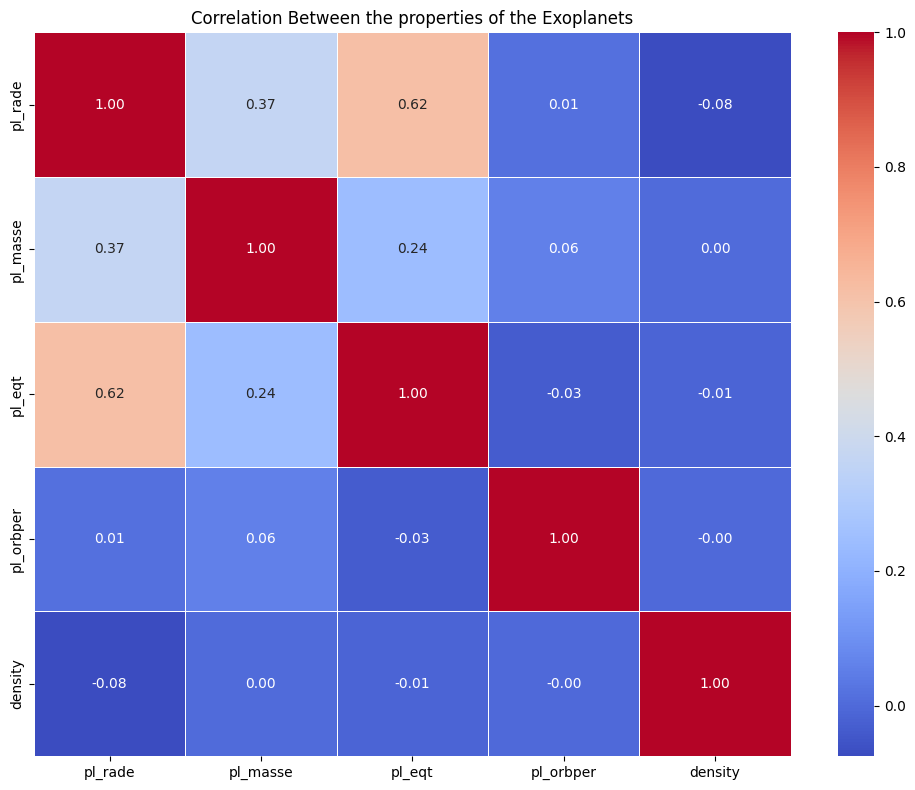

In [36]:
#We use a heatmap!! (I like how they look :))
cols_of_interest = ['pl_rade', 'pl_masse', 'pl_eqt', 'pl_orbper', 'density']
df_corr = df[cols_of_interest].dropna()

corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between the properties of the Exoplanets')
plt.tight_layout()
plt.show()

There are three things to keep in mind to read a heat map:


1.   A negative coefficient means that there is negative correlation between the properties.This refers to an inverse relationship between the properties.
2.   A zero means there is no relationship there.
3.  And a positive correlation coefficient means that there is a direct relationship.

The 1 means that we are talking about the same property.

Now, we can see that there is a direct relationship between the planetary radius and the orbital period which is quite interesting - the planetary radius increases with an increase in the orbital period. So, the slower the planet's revolution, the larger it is!
On the other hand, the radius increases with a decrease in density!



### Are the exoplanets distant from their host stars? We find out without using their orbital period using a simple relation.

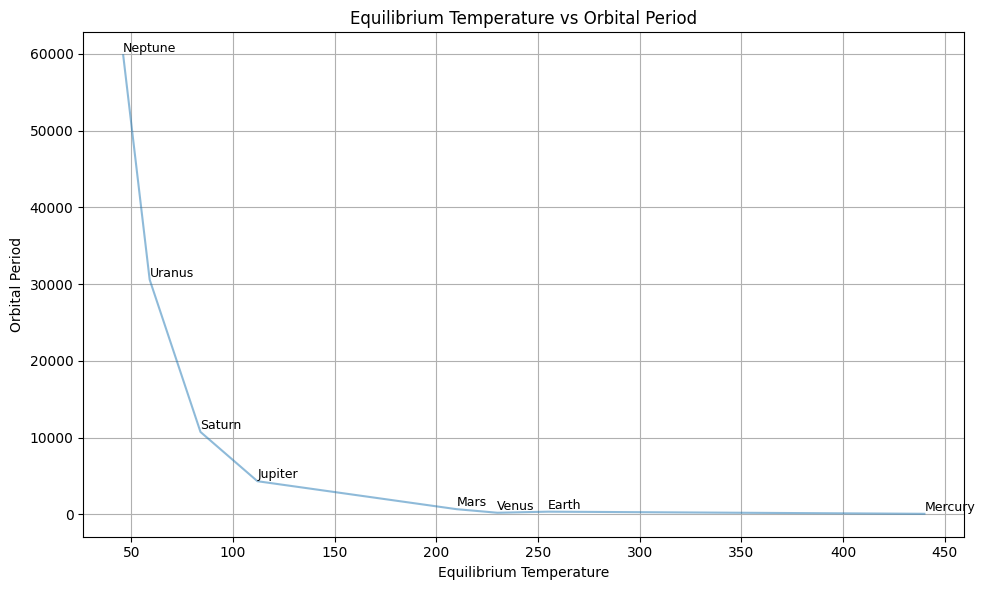

In [37]:
#We check for our own solar system first and form a hypothesis.
plt.figure(figsize=(10, 6))
sns.lineplot(data=reference_df, x='pl_eqt', y='pl_orbper', alpha=0.5)

#I want to label the plot so that we can see which planet corresponds to which value.
for i in range(len(reference_df)):
    plt.text(reference_df['pl_eqt'][i], reference_df['pl_orbper'][i], reference_df['pl_name'][i], fontsize=9, ha='left', va='bottom')

plt.xlabel('Equilibrium Temperature')
plt.ylabel('Orbital Period')
plt.title('Equilibrium Temperature vs Orbital Period')
plt.grid(True)
plt.tight_layout()
plt.show()

Using this plot, we can make a hypothesis that the proximity of the exoplanet with its host star can be determined with the use of the temperature. Higher the temperature, closer the star. Let's see.

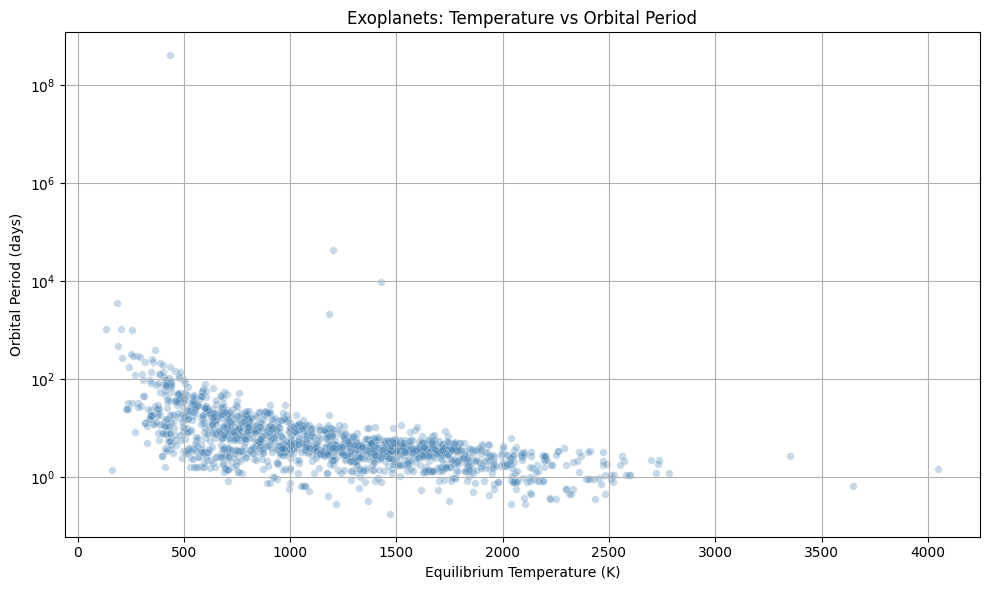

In [38]:
#I use a scatterplot here because after using a lineplot, I found that a large dataset can make a very confusing lineplot which isnt very comprehensible - it has a peak and is zero everywhere else.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pl_eqt', y='pl_orbper', alpha=0.3, s=30, color='steelblue')

plt.yscale('log')  #I used the log scale for the wide range of orbital periods
plt.xlabel('Equilibrium Temperature (K)')
plt.ylabel('Orbital Period (days)')
plt.title('Exoplanets: Temperature vs Orbital Period')
plt.grid(True)
plt.tight_layout()
plt.show()

Now, we can clearly see that the lower the temperatures, the farther away the planet is from the host star. Hence, our assumption is correct and we can use the temperature to make a guess about the distance between the host star and its planets.

### Can we find a relation between the temperature and density? Do planets with higher temperatures have lower densities?

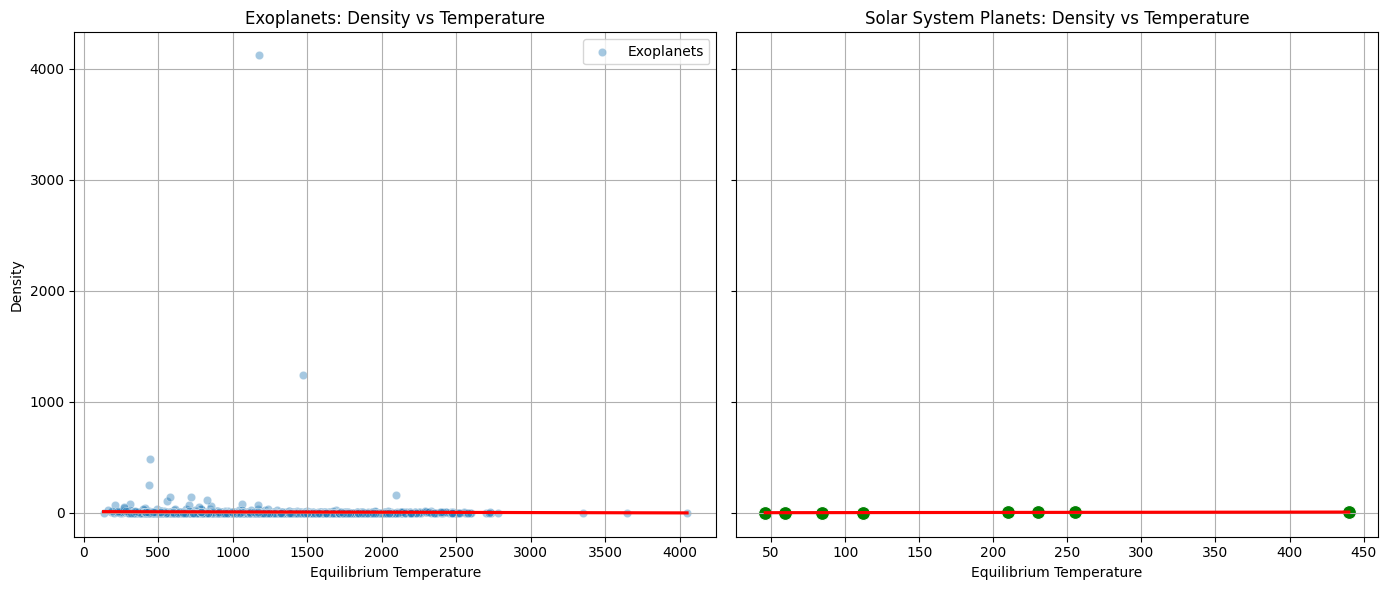

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#For the exoplanets
sns.scatterplot(data=df, x='pl_eqt', y='density', alpha=0.4, ax=axes[0], label='Exoplanets')
sns.regplot(data=df, x='pl_eqt', y='density', scatter=False, color='red', ax=axes[0])
axes[0].set_xlabel('Equilibrium Temperature')
axes[0].set_ylabel('Density')
axes[0].set_title('Exoplanets: Density vs Temperature')
axes[0].grid(True)

#For the soalr system planets
sns.scatterplot(data=reference_df, x='pl_eqt', y='density', s=100, ax=axes[1], color='green')
sns.regplot(data=reference_df, x='pl_eqt', y='density', scatter=False, color='red')
axes[1].set_xlabel('Equilibrium Temperature')
axes[1].set_ylabel('Density')
axes[1].set_title('Solar System Planets: Density vs Temperature')
axes[1].grid(True)

plt.tight_layout()
plt.show()

We have to look at two things here first- the slope of the regression line and the scattering of the points.

Since, we have a flat line and no slope, we can conclude that there is no clear/distinct relation between the temperature and the density of the exoplanets in our data. The scattering of the points is also away from the line. This makes sense because temperature is mainly influenced by the orbital period which tells us how close the planet is to its host star. The density is about the overall composition of the planet. We can check this same conclusion one more way.

In [40]:
df[['pl_eqt', 'density']].corr()

,pl_eqt,density
pl_eqt,1.000000,-0.014425
density,-0.014425,1.000000


The negative coefficient tells us that there is strong negative correlation between the two parameters.

If we see the same for the solar system planets, we will find that while the slope is flat, the points are scattered around the line which signifies a strong correlation. This is because of two reasons:


1.   There are only 8 points to consider here which makes the slope flat.
2.   In our solar system, the density and temperature don't have anything to do with each other either. But they are arranged in an descending order according to their temperature and density both (coincidentally or not?) which makes it seem like the two are correlated.



In [41]:
reference_df[['pl_eqt', 'density']].corr()

,pl_eqt,density
pl_eqt,1.000000,0.871422
density,0.871422,1.000000


As expected, we get a positive coefficient in the case of our solar system planets.

### Do people talk more about extraterrestrial life and space during dicovery years?

In [42]:
#I had already included the timestamps and converted to datetime.
dfr['year'] = dfr['created_utc'].dt.year
dfr['text'] = dfr['title'].fillna('') + ' ' + dfr.get('selftext', '').fillna('')


def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

dfr['clean_text'] = dfr['text'].apply(clean_text)

vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(dfr['clean_text'])

keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
keywords_df['year'] = dfr['year'].values
keyword_yearly = keywords_df.groupby('year').sum()

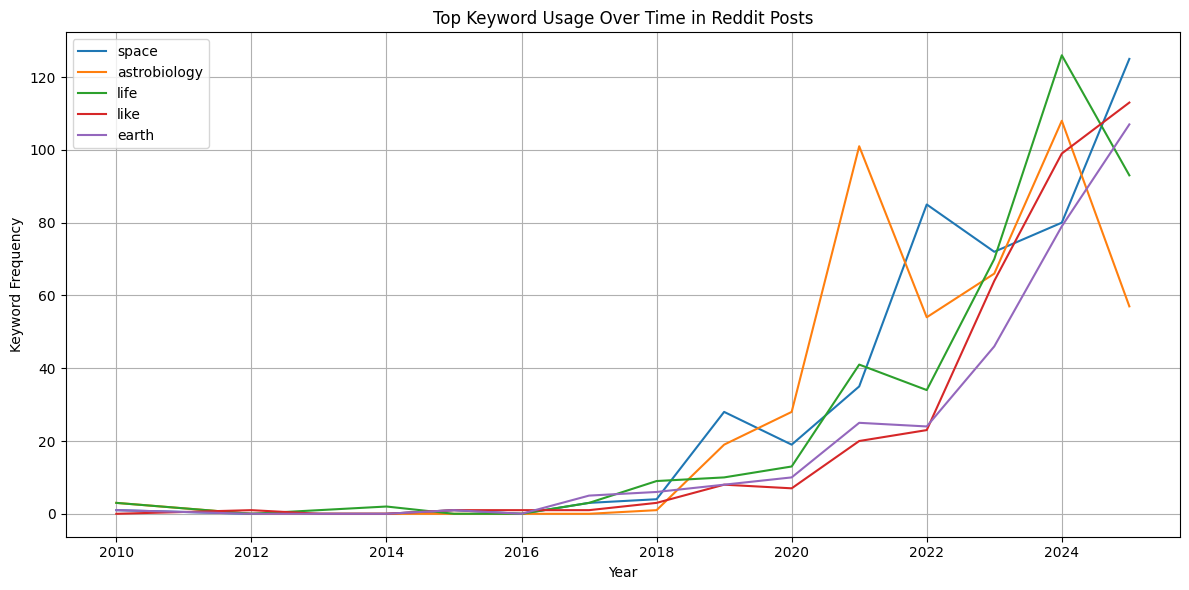

In [43]:
top_keywords = keyword_yearly.sum().sort_values(ascending=False).head(5).index

plt.figure(figsize=(12, 6))
for kw in top_keywords:
    plt.plot(keyword_yearly.index, keyword_yearly[kw], label=kw)

plt.xlabel("Year")
plt.ylabel("Keyword Frequency")
plt.title("Top Keyword Usage Over Time in Reddit Posts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This is the trend in keywords related to extraterrestrial life and exoplanetary science on the social platform, Reddit.

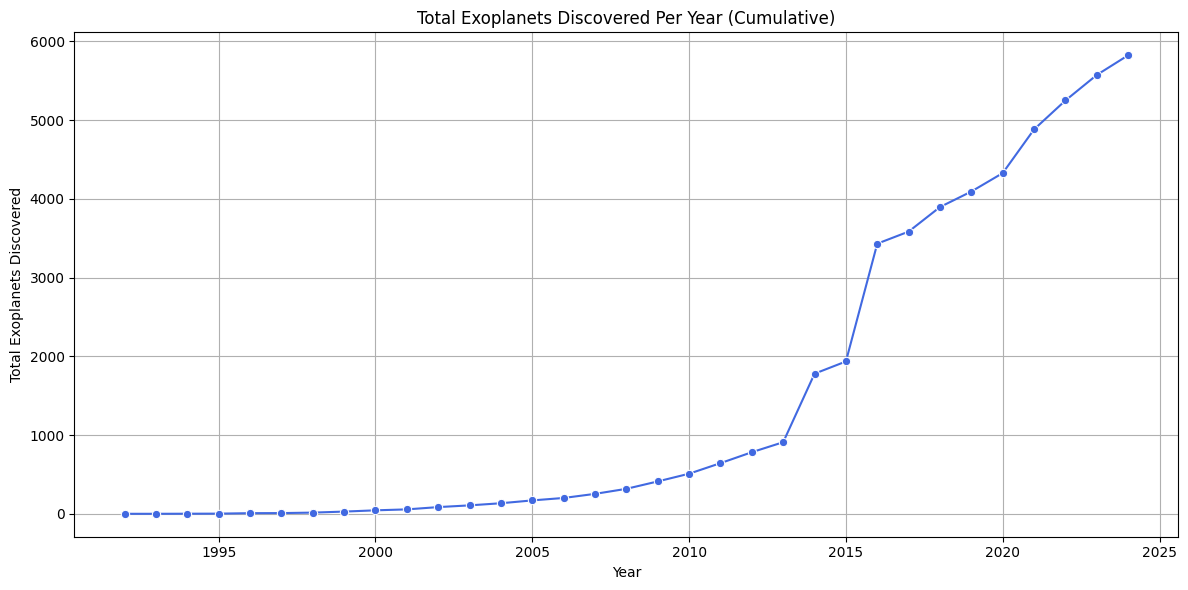

In [44]:
plt.figure(figsize=(12,6))
sns.lineplot(data=dfplt, x='Year', y='total_discoveries', marker='o', color='royalblue')

plt.title("Total Exoplanets Discovered Per Year (Cumulative)")
plt.xlabel("Year")
plt.ylabel("Total Exoplanets Discovered")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot tells us how exoplanetary science has evolved and how we have found more and more exoplanets over the years.

If you look clearfully, you will find that the two plots have a similar slope. This shows that there is a direct relationship between people's sentiments towards extraterrestrial science and exoplanetary discoveries.

### Conclusion and Future Work

We were able to draw quite a lot of conclusions with the help of EDA and simple analysis using Python.

Firstly, we saw that exoplanets resemble the planets in our solar system a lot. With the help of the heatmap and other sns plots, we were able to answer the following questions one might have about the two types of planet models:
1. How are moons distributed amongst the exoplanets?
2. How can we determine whether an exoplanet is a terrestrial planet, a gas giant, or an ice giant?
3. What is the relation between the different properties of the planets?
4. Can we use these relations to make hypotheses about the planets? For instance, we showed how the orbital period-temperature relation allows us to guess how close the planet is to its host star just by looking at its temperature.
5. What's the relation between the temperature and density of the planets? What do correlation coefficients tell us?

Other than this, we used two other datasets to check how people think about the space sciences. The Reddit dataset showed us that there is a boom in people talking about topics related to exoplanets when there is any big discovery of the same.

There could have been more data regarding the latter, is what I feel like. I was enable to find much data in the form of surveys and such. So, for future projects and analysis, I think there should be more reports about the public and their knowledge about the space.

### References and Sources



*   NASA Exoplanet Archive — https://exoplanetarchive.ipac.caltech.edu/
Source of physical parameters (Planet Mass, Planet Radius, Orbital Period, Equilibrium Temperature) for confirmed exoplanets.
*   NASA Planetary Fact Sheet: https://nssdc.gsfc.nasa.gov/planetary/factsheet/  
  Source of the physical parameters of the planets in our solar system.
*   Python Libraries used: 'Pandas', 'Numpy', 'Scipy', 'Statsmodels', 'Matplotlib', 'Seaborn', 'Warnings', 'Async PRAW', 'datetime', 're', 'sklearn'.
*   Cermak, A. (2024, October 26). Gas Giant - NASA Science. NASA Science. https://science.nasa.gov/exoplanets/gas-giant/
*   NASA (2025) – with major processing by Our World in Data. “Cumulative number of exoplanets discovered, by method” [dataset]. NASA, “NASA Exoplanet Archive” [original data]. Retrieved July 1, 2025 from https://archive.ourworldindata.org/20250624-125417/grapher/cumulative-exoplanets-by-method.html (archived on June 24, 2025).
*   Deeg, H.-J. & Instituto de Astrofísica de Canarias. (n.d.). Impact of exoplanet science on society: professional contributions, citizen science engagement and public perception. In Instituto De Astrofísica De Canarias [Journal-article]. https://arxiv.org/pdf/2410.07285
*   GeeksforGeeks. (2025, May 10). What is Exploratory Data Analysis? GeeksforGeeks. https://www.geeksforgeeks.org/data-analysis/what-is-exploratory-data-analysis/
*   Visual data analysis in Python. Part 2. Overview of Seaborn, Matplotlib and Plotly libraries — mlcourse.ai. (n.d.). https://mlcourse.ai/book/topic02/topic02_additional_seaborn_matplotlib_plotly.html
*   All Exoplanets Dataset. (2021, November 25). https://www.kaggle.com/datasets/shivamb/all-exoplanets-dataset
*   preferences (reddit.com). (n.d.). https://www.reddit.com/prefs/apps






